# This notebook is to create the dataframe with the audio as vector and label.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [2]:
pip install pydub

In [3]:
pip install tensorflow_io

In [4]:
import numpy as np
import pandas as pd
import scipy.io.wavfile as wavfile
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt


from tensorflow.keras import layers
from tensorflow.keras import models

# set random seed for reproducibility
seed = 920
tf.random.set_seed(seed)
np.random.seed(seed)

@misc{TFDS,
  title = {{TensorFlow Datasets}, A collection of ready-to-use datasets},
  howpublished = {\url{https://www.tensorflow.org/datasets}},
}


# Load Data

In [5]:

train, test, val = tfds.load( "speech_commands", 
                             split=["train", 'test', 'validation'],
                             shuffle_files = True,
                             as_supervised = True)
assert isinstance(train, tf.data.Dataset)
assert isinstance(test, tf.data.Dataset)
assert isinstance(val, tf.data.Dataset)


# EDA

print type of train, test and validation sets

In [6]:
print(train)
print(test)
print(val)

<_OptionsDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>
<_OptionsDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>
<_OptionsDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>


print info about the classes, label names <br>
create a list of label names called commands

In [7]:

builder = tfds.builder('speech_commands')
info = builder.info
print(info)
commands = info.features['label'].names
print(info.features['label'].num_classes)
print(f'Commands {commands}')


tfds.core.DatasetInfo(
    name='speech_commands',
    version=0.0.2,
    description='An audio dataset of spoken words designed to help train and evaluate keyword
spotting systems. Its primary goal is to provide a way to build and test small
models that detect when a single word is spoken, from a set of ten target words,
with as few false positives as possible from background noise or unrelated
speech. Note that in the train and validation set, the label "unknown" is much
more prevalent than the labels of the target words or background noise.
One difference from the release version is the handling of silent segments.
While in the test set the silence segments are regular 1 second files, in the
training they are provided as long segments under "background_noise" folder.
Here we split these background noise into 1 second clips, and also keep one of
the files for the validation set.',
    homepage='https://arxiv.org/abs/1804.03209',
    features=FeaturesDict({
        'audio': Audio(shap

print info about the shapes and dtypes
<br>
print information about the splits

In [8]:

print(info.features.shape)
print(info.features['audio'].shape)
print(list(info.splits.keys()))

{'audio': (None,), 'label': ()}
(None,)
['test', 'train', 'validation']


Print information about training data

In [9]:
train_info = train.take(1)
for audio, label in train_info:
   print(f'audio shape: {audio.shape} , audio dtype {audio.dtype}')
   print(f'label: {label}')


audio shape: (16000,) , audio dtype <dtype: 'int64'>
label: 0


Print examples of audio commands as waveform.


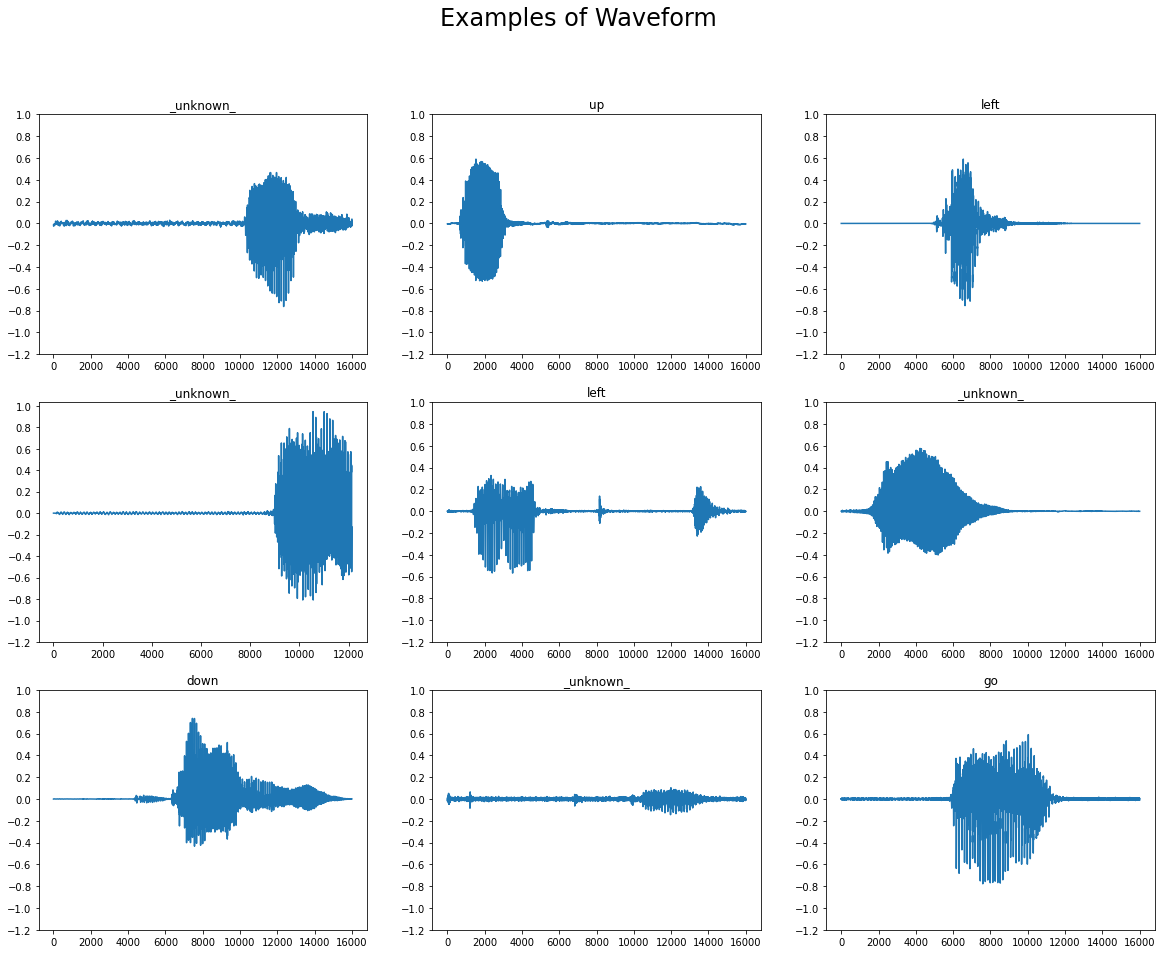

In [10]:
# a plot of some a few audio waveforms

rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))


#for i, (audio, label) in enumerate(waveform_ds.take(n)):
for i, (audio, label) in enumerate(train.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(tf.cast(audio, tf.float32) / 32768.0)
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy()
  ax.set_title(commands[label])

plt.suptitle('Examples of Waveform', fontsize = 24, va = 'top', x = 0.5, y = .98)
fig1 = plt.gcf()
plt.show()
fig1.savefig('./drive/MyDrive/audio_commands/visuals/waveform.png');

Play an example of audio commands

In [11]:

from IPython.display import Audio
from pydub import AudioSegment

for waveform, label in train.take(1):

  fade = tfio.audio.fade(
   waveform.numpy(), fade_in=1000, fade_out=2000, mode="logarithmic")
  spectrogram = tfio.audio.spectrogram(
    fade, nfft=512, window=512, stride=256)
  command = commands[label.numpy()]
print(label.numpy())
print('Label:', command)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')


Audio(waveform.numpy(), rate=16000)


10
Label: _silence_
Waveform shape: (16000,)
Spectrogram shape: (63, 257)
Audio playback


Plot and example of waveform over time with corresponding spectrogram(frequencies overtime).

In [12]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

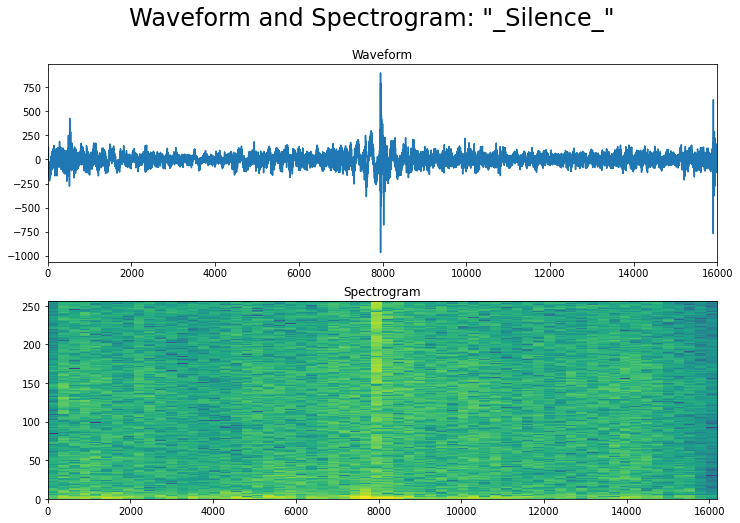

In [13]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')

command = commands[label.numpy()]
title = 'Waveform and Spectrogram: "' + command.title() +'"'
#fig.tight_layout()
plt.suptitle(title, fontsize = 24, va = 'top', x = 0.5, y = .98)
fig1 = plt.gcf()
plt.show()
fig1.savefig('./drive/MyDrive/audio_commands/visuals/waveform_spectrogram.png', pad_inches = 1);